In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* List of items in the bin

In [3]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [4]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [5]:
contents = [s.lower() for s in contents]

## Phase 1: Recognition by SIFT Features
### Compute Features in Bin

1067 features detected in bin


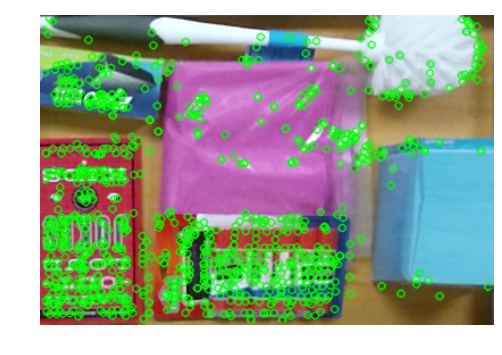

In [6]:
from utils import imread_rgb, compute_sift, draw_keypoints

filename_bin = 'bin/' + bin_stamp + '.png'
image_bin = imread_rgb(filename_bin)
(kp_bin, des_bin) = compute_sift(image_bin)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

### Optional: apply mask to textured region

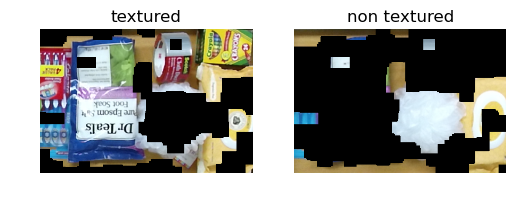

In [6]:
from utils import textured_mask

tx_mask = textured_mask(image_bin, kp_bin)
tx_image =     cv2.bitwise_and(image_bin, image_bin, mask=tx_mask)
non_tx_image = cv2.bitwise_and(image_bin, image_bin, mask=255-tx_mask)
plt.subplot(121), plt.imshow(tx_image),     plt.axis('off'), plt.title('textured');
plt.subplot(122), plt.imshow(non_tx_image), plt.axis('off'), plt.title('non textured');

In [ ]:
(kp_bin, des_bin) = compute_sift(image_bin, mask=tx_mask)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

### Match Bin and Items Features

#### First iteration
Compute features for all the items

In [7]:
from utils import read_features_from_file, read_bbox_from_file, unpack_keypoint, calc_matches

items = list(contents)

Item: "Training_items/colgate_toothbrush_4pk/colgate_toothbrush_4pk_top_01_sift.npy" Good features: 12
Item: "Training_items/epsom_salts/epsom_salts_top_01_sift.npy" Good features: 55
Item: "Training_items/duct_tape/duct_tape_top_01_sift.npy" Good features: 2
Item: "Training_items/bath_sponge/bath_sponge_top_01_sift.npy" Good features: 5
Item: "Training_items/crayons/crayons_top_01_sift.npy" Good features: 38
Item: "Training_items/burts_bees_baby_wipes/burts_bees_baby_wipes_top_01_sift.npy" Good features: 10


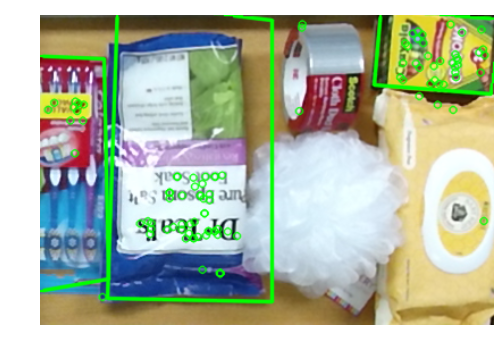

In [8]:
item_d = {}
recognised_items = []
image_disp = image_bin.copy()
mask_bin = np.zeros(image_bin.shape[0:2]).astype('uint8')
for item in items:
    prefix = ITEM_FOLDER + '/' + item + '/' + item
    filename = prefix + '_top_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}
    
    filename = prefix + '_bottom_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    if len(good) > len(item_d[item]['good']):
        item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}

    print('Item: "%s" Good features: %d' % (item_d[item]['file'], 
                                          len(item_d[item]['good'])))
    MIN_MATCH_COUNT=10
    kp = item_d[item]['kp']
    good = item_d[item]['good']
    if len(good) > MIN_MATCH_COUNT:
        dst_pts = [ kp_bin[m.trainIdx] for m in good ]
        image_disp = cv2.drawKeypoints(image_disp,dst_pts,color=(0,255,0))
        recognised_items.append(item)
        src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_bin[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        #matchesMask = mask.ravel().tolist()
        x, y, w, h = read_bbox_from_file(item_d[item]['file'][:-9] + '_bbox.json')
        pts = np.float32([ [x,y],[x,y+h-1],[x+w-1,y+h-1],[x+w-1,y] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(image_disp,[np.int32(dst)],True,(0,255,0),2, cv2.CV_AA)
        cv2.fillConvexPoly(mask_bin,np.int32(dst),(255,))

plt.imshow(image_disp), plt.axis('off');

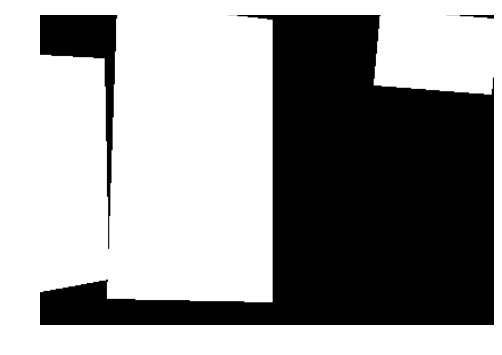

In [9]:
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

#### Second iteration
Refine features in the projection of the items recognised in the first iteration

881 features detected in bin


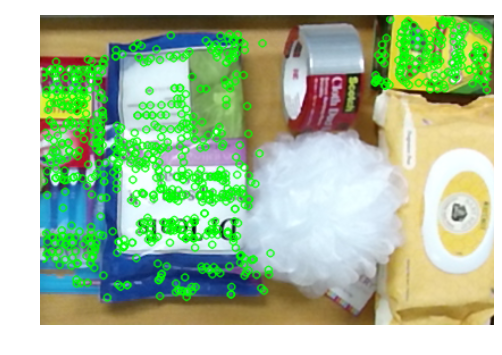

In [10]:
(kp_bin, des_bin) = compute_sift(image_bin, mask=mask_bin)
print('%d features detected in bin' % len(kp_bin))
draw_keypoints(image_bin,kp_bin)

In [11]:
items = recognised_items

Item: "Training_items/colgate_toothbrush_4pk/colgate_toothbrush_4pk_top_01_sift.npy" Good features: 12
Item: "Training_items/epsom_salts/epsom_salts_top_01_sift.npy" Good features: 54
Item: "Training_items/crayons/crayons_top_01_sift.npy" Good features: 37


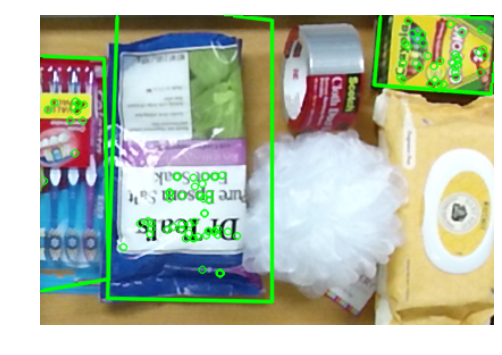

In [12]:
item_d = {}
recognised_items = []
image_disp = image_bin.copy()
mask_bin = np.zeros(image_bin.shape[0:2]).astype('uint8')
for item in items:
    prefix = ITEM_FOLDER + '/' + item + '/' + item
    filename = prefix + '_top_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}
    
    filename = prefix + '_bottom_01_sift.npy'
    kp, des = read_features_from_file(filename)
    kp, des = unpack_keypoint(kp, des)
    des = des.astype('float32')
    good = calc_matches(des, des_bin)
    if len(good) > len(item_d[item]['good']):
        item_d[item] = {'file': filename, 'kp': kp, 'des': des, 'good': good}

    print('Item: "%s" Good features: %d' % (item_d[item]['file'], 
                                          len(item_d[item]['good'])))
    MIN_MATCH_COUNT=10
    kp = item_d[item]['kp']
    good = item_d[item]['good']
    if len(good) > MIN_MATCH_COUNT:
        dst_pts = [ kp_bin[m.trainIdx] for m in good ]
        image_disp = cv2.drawKeypoints(image_disp,dst_pts,color=(0,255,0))
        recognised_items.append(item)
        src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_bin[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        x, y, w, h = read_bbox_from_file(item_d[item]['file'][:-9] + '_bbox.json')
        pts = np.float32([ [x,y],[x,y+h-1],[x+w-1,y+h-1],[x+w-1,y] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        cv2.polylines(image_disp,[np.int32(dst)],True,(0,255,0),2, cv2.CV_AA)
        cv2.fillConvexPoly(mask_bin,np.int32(dst),(255,))

plt.imshow(image_disp), plt.axis('off');

colgate_toothbrush_4pk recognised with 12 features
         epsom_salts recognised with 54 features
             crayons recognised with 37 features


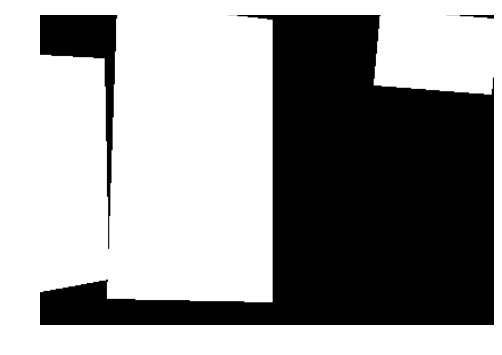

In [13]:
for it in recognised_items:
    print('%20s recognised with %d features' %(it, len(item_d[it]['good'])))
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

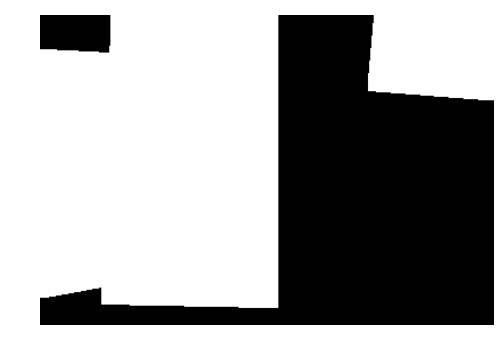

In [14]:
kernel = np.ones((3,3),np.uint8)
mask_bin = cv2.dilate(mask_bin,kernel,iterations = 5)
plt.imshow(mask_bin,cmap='gray'), plt.axis('off');

## Phase 2: Recognition by Color

In [15]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans

n_cc = 20
image_RGBA = np.dstack((image_bin, 255-mask_bin))
pixels = image_RGBA.reshape((image_RGBA.shape[0] * image_RGBA.shape[1], 4))
filtered_pixels = np.array(filter(lambda x:x[3]==255,pixels))
n, _ = filtered_pixels.shape
pixels_LAB = cv2.cvtColor(filtered_pixels[:,0:3].reshape(1,n,3),cv2.COLOR_RGB2LAB)
pixels_LAB = pixels_LAB.reshape(n,3)
clt = MiniBatchKMeans(n_clusters = n_cc)
clt.fit(pixels_LAB)

CPU times: user 314 ms, sys: 0 ns, total: 314 ms
Wall time: 313 ms


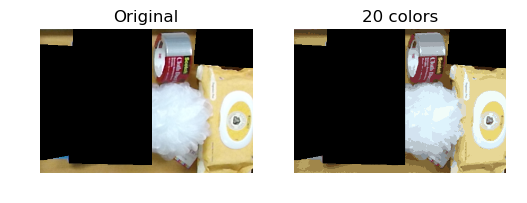

In [16]:
image = cv2.cvtColor(image_bin, cv2.COLOR_RGB2LAB)
(h_bin, w_bin) = image.shape[:2]
pixels = image.reshape((image.shape[0] * image.shape[1], 3))
labels = clt.predict(pixels)
quant = clt.cluster_centers_.astype("uint8")[labels]
quant = quant.reshape((h_bin, w_bin, 3))
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
plt.subplot(121),plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=255-mask_bin)),plt.title('Original'),plt.axis('off');
plt.subplot(122),plt.imshow(cv2.bitwise_and(quant,quant,mask=255-mask_bin)),plt.title('%d colors' % n_cc),plt.axis('off');
bin_cc = clt.cluster_centers_

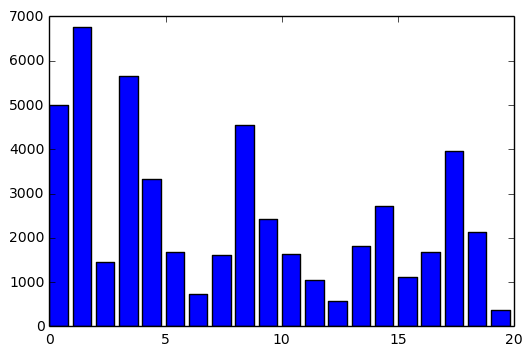

In [17]:
h, _ = np.histogram(clt.predict(pixels_LAB),bins=range(n_cc+1))
plt.bar(range(n_cc), h);

In [18]:
sort_index = np.argsort(h)[::-1]
sort_index

array([ 1,  3,  0,  8, 17,  4, 14,  9, 18, 13, 16,  5, 10,  7,  2, 15, 11,
        6, 12, 19])

### While not sort_index is empty

In [33]:
obj_label = sort_index[0]
d_other = [np.linalg.norm(bin_cc[obj_label,1:]-bin_cc[other,1:]) for other in sort_index]
obj_labels = [sort_index[idx] for idx,val in enumerate(d_other) if val<20]
obj_labels

[2, 19]

In [34]:
# Weighting the histogram of dominant colors 
obj_hist = np.array([h[obj_l] for obj_l in obj_labels],dtype='float32')
obj_hist = obj_hist / np.sum(obj_hist)
obj_hist

array([ 0.79473108,  0.20526893], dtype=float32)

In [35]:
sort_index = np.array([x for x in sort_index if x not in obj_labels])
sort_index

array([12])

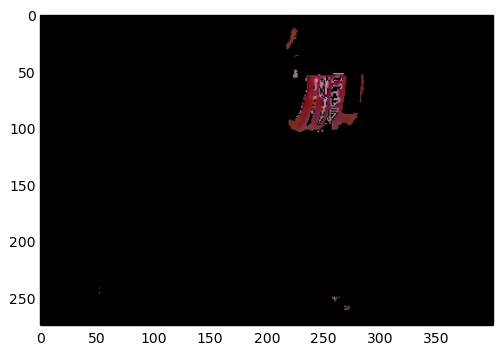

In [36]:
mask = np.zeros((h_bin, w_bin)).astype('uint8')
for val_label in obj_labels:
    mask = cv2.bitwise_or( mask, ((labels==val_label).astype('uint8') * 255).reshape((h_bin, w_bin)) )
mask = cv2.bitwise_and( mask, 255-mask_bin)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=mask));

In [37]:
recognised_items

['colgate_toothbrush_4pk', 'epsom_salts', 'crayons']

In [38]:
items = [s for s in contents if s not in recognised_items]
items

['duct_tape', 'bath_sponge', 'burts_bees_baby_wipes']

In [39]:
best_item = []
views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
for item in items:
    for view in views:
        try:
            filename = ITEM_FOLDER + '/' + item + '/' + item + '_' + view + '_dc.json'
            dc = read_json(filename)
            hist = dc['hist']
            obj_cc = dc['cluster_centers']
            sum_h = 0
            for i in range(5):
                d_bin_obj = [np.linalg.norm(obj_cc[i]-bin_cc[obj_l,:]) for obj_l in obj_labels]
                index_min = np.argmin(d_bin_obj)
                if d_bin_obj[index_min] < 25:
                    sum_h += hist[i] * obj_hist[index_min]
                #if min([np.linalg.norm(obj_cc[i]-bin_cc[obj_l,:]) for obj_l in obj_labels]) < 25:
                #    sum_h += hist[i]
            if sum_h > 0:
                best_item.append((sum_h,item,view))
        except IOError:
            pass
best_item = sorted(best_item,reverse=True)
best_item

[(0.036011823552412503, 'burts_bees_baby_wipes', 'bottom-side_01'),
 (0.015950887636914789, 'burts_bees_baby_wipes', 'top-side_02'),
 (0.013234408605330875, 'bath_sponge', 'bottom_01'),
 (0.0053990023038653105, 'burts_bees_baby_wipes', 'bottom_01')]

In [60]:
#recognised_items.append(best_item[0][1])

### End While